In [0]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
epoch = 30
batchSize = 128
latentDim = 16


((trainX, trainY), (testX, testY)) = mnist.load_data()
print("Number of training data points",len(trainX))
print("Number of test data points",len(testX))

trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

#Adding noise to data with mean as 0.5 and std as 0.5
trainNoise = np.random.normal(loc=0.5, scale=0.5, size=trainX.shape)
testNoise = np.random.normal(loc=0.5, scale=0.5, size=testX.shape)
trainXNoisy = np.clip(trainX + trainNoise, 0, 1)
testXNoisy = np.clip(testX + testNoise, 0, 1)

#Model
inputShape=trainX[0].shape

def convLayer(filters,kernel_size,
              strides,layer):
  layer = Conv2D(filters,
               kernel_size,strides,
               activation='relu',padding='same')(layer)
  layer=MaxPooling2D(pool_size = (2,2), strides = 2)(layer)
  return layer

def convTranspose(filters,
               kernel_size,strides,
               activation,padding,layer):
  layer=Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,activation=activation,
                        padding='same')(layer)
  return layer

inputs = Input(shape=inputShape)
layer=convLayer(16,3,1,inputs)
layer=convLayer(32,3,1,layer)

#Latent Space
layer = Flatten()(layer)
encoded = Dense(latentDim)(layer)

layer = Dense(1568, activation='relu')(encoded)
layer = Reshape((7, 7, 32))(layer)


layer=convTranspose(32,3,2,'relu','same',layer)
layer=convTranspose(16,3,2,'relu','same',layer)
output=Conv2DTranspose(filters=1,
                        kernel_size=3,
                        activation='relu',
                        padding='same')(layer)

autoencoder = Model(inputs, output, name='autoencoder')
autoencoder.summary()

autoencoder.compile(loss='mse', optimizer='adam')

autoencoder.fit(trainXNoisy,
                trainX,
                validation_data=(testXNoisy, testX),
                epochs=30,
                batch_size=128)

x_decoded = autoencoder.predict(testXNoisy)


Number of training data points 60000
Number of test data points 10000
Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1568)              0         
___________________________________________________

In [0]:
autoencoder.save_weights('/content/Denoising_ConvolutionAutoEncoderWeights.hdf5')

## Predicions on Test Data


<Figure size 576x288 with 0 Axes>

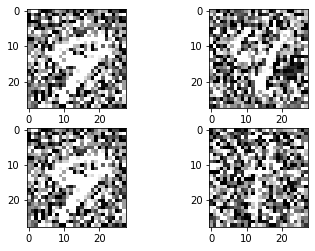

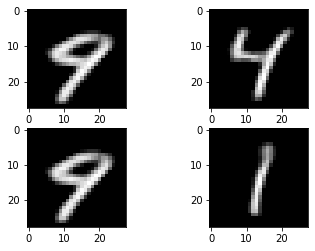

In [0]:
index=[]
nrows=2
ncols=2

plt.figure(figsize=(8,4))
fig, ax = plt.subplots(nrows=2, ncols=2)

for i in range(1,nrows*ncols+1):
  plt.subplot(2, 2, i)
  idx = np.random.randint(0,10)
  index.append(idx)
  img = testXNoisy[idx]
  plt.imshow(np.squeeze(img),cmap='gray')
plt.show()

for i in range(1,nrows*ncols+1):
  plt.subplot(2, 2, i)
  img = testXNoisy[index[i-1]]
  img = np.expand_dims(img, axis=0)
  img = np.expand_dims(img, axis=-1)
  plt.imshow(np.squeeze(autoencoder.predict(img)),cmap='gray')
plt.show()


In [0]:
index

[9, 0, 2, 7]